# Course 3, Part f: Boosting and Stacking LAB
Estimated time needed: 45 minutes

Objectives
After completing this demo you will be able to:

Understand how Gradient Boosting helps reduce error
Identify the benefits of using AdaBoost
Interpret the benefits of stacking models and comparing their results to boosted models

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided:

*   Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
*   Triaxial angular velocity from the gyroscope.
*   A 561-feature vector with time and frequency domain variables.
*   Its activity label.

More information about the features is available on the website shown above.


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

In [2]:
data = pd.read_csv("Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

In [3]:
data.shape

(10299, 562)

In [4]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [5]:
data.dtypes

tBodyAcc-mean()-X                       float64
tBodyAcc-mean()-Y                       float64
tBodyAcc-mean()-Z                       float64
tBodyAcc-std()-X                        float64
tBodyAcc-std()-Y                        float64
                                         ...   
angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
Length: 562, dtype: object

How to find object type column in the dataframe. we can find any type of column from the dataset

In [6]:
object_columns = data.select_dtypes(include=['object']).columns
object_columns

Index(['Activity'], dtype='object')

The minimum and maximum value for the float columns is -1.0 and 1.0, respectively. However, scaling is never required for tree-based methods.


In [7]:
# Mask to select float columns
float_columns = (data.dtypes == np.float)

# Verify that the maximum of all float columns is 1.0
print( (data.loc[:,float_columns].max()==1.0).all() )

# Verify that the minimum of all float columns is -1.0
print( (data.loc[:,float_columns].min()==-1.0).all() )

### END SOLUTION

True
True


In [8]:
# we check min value in all rows and exclude last column by -1 after : (last column is object column)
# we can also used the drop command X = data.drop('Activity', axis=1)
data.iloc[:, :-1].min()
# The result shows that min value of the feature variables is -1

tBodyAcc-mean()-X                      -1.0
tBodyAcc-mean()-Y                      -1.0
tBodyAcc-mean()-Z                      -1.0
tBodyAcc-std()-X                       -1.0
tBodyAcc-std()-Y                       -1.0
                                       ... 
angle(tBodyGyroMean,gravityMean)       -1.0
angle(tBodyGyroJerkMean,gravityMean)   -1.0
angle(X,gravityMean)                   -1.0
angle(Y,gravityMean)                   -1.0
angle(Z,gravityMean)                   -1.0
Length: 561, dtype: float64

In [9]:
data.iloc[:, :-1].min().value_counts()  # no of min values

-1.0    561
dtype: int64

In [10]:
# finding max values in all rows & columns exclusing last column
data.iloc[:, :-1].max()#.value_counts() 

tBodyAcc-mean()-X                       1.0
tBodyAcc-mean()-Y                       1.0
tBodyAcc-mean()-Z                       1.0
tBodyAcc-std()-X                        1.0
tBodyAcc-std()-Y                        1.0
                                       ... 
angle(tBodyGyroMean,gravityMean)        1.0
angle(tBodyGyroJerkMean,gravityMean)    1.0
angle(X,gravityMean)                    1.0
angle(Y,gravityMean)                    1.0
angle(Z,gravityMean)                    1.0
Length: 561, dtype: float64

In [11]:
# label encoding last column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Activity'] = le.fit_transform(data['Activity'])
le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [12]:
data.Activity.unique()  # 0 is for standing

array([2, 1, 0, 3, 4, 5])

In [13]:
data['Activity'].value_counts()#.sample(6)
#result shows that each of the six string catagories are converted into integers with values 
# decending order. By attaching .sample() function it will give in any order

0    1944
2    1906
1    1777
3    1722
5    1544
4    1406
Name: Activity, dtype: int64

NOTE: We are about to create training and test sets from data. On those datasets, we are going to run grid searches over many choices of parameters. This can take some time. In order to shorten the grid search time, feel free to downsample data and create X_train, X_test, y_train, y_test from the downsampled dataset.

Now split the data into train and test data sets. A stratified split was not used here. If there are issues with any of the error metrics on the test set, it can be a good idea to start model fitting over using a stratified split. Boosting is a pretty powerful model, though, so it may not be necessary in this case.

In [14]:
from sklearn.model_selection import train_test_split
# Alternatively, we could stratify the categories in the split
feature_columns = [x for x in data.columns if x != 'Activity']

X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data['Activity'],
                 test_size=0.3, random_state=42)


In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7209, 561), (7209,), (3090, 561), (3090,))

Question 3
Fit gradient boosted tree models with max features 5 and with all parameters set to their defaults with the following tree numbers (n_estimators = [15, 25, 50, 100, 200, 400]) and evaluate the accuracy on the test data for each of these models.
Plot the accuracy as a function of estimator number.
Note: there is no out-of-bag error for boosted models. And the warm_flag=True setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the for loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively. Note: If we set maximum features equal to none i.e if all the features will be taken in the model, it will took around 25 minutes to run, so we set maximum features 5 in the GradientBoosterClassifier

In [16]:
### BEGIN SOLUTION
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(max_features=5, n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 200 trees
Fitting model with 400 trees


,error
n_trees,
15.0,0.104854
25.0,0.072492
50.0,0.040129
100.0,0.024595
200.0,0.015210
400.0,0.014239


We see the error reduces with the increase in trees and after 200 trees the difference in error reduction is not too much comparatively

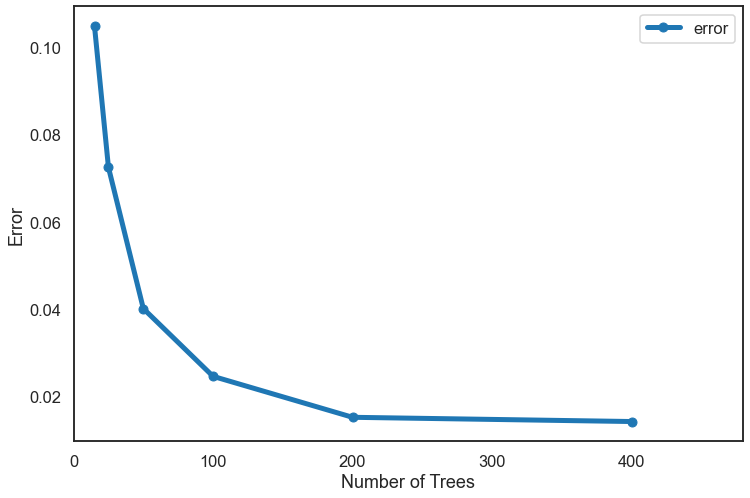

In [17]:
sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.2);# set limit of xaxis to max index of error_df*1.1 = 440
### END SOLUTION

Question 4
Using a grid search with cross-validation, fit a new gradient boosted classifier with the same list of estimators as question 3. Also try varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
Examine the parameters of the best fit model.
Calculate relevant error metrics on this model and examine the confusion matrix.

In [18]:
### BEGIN SOLUTION
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In Python, "pickle" refers to the serialization module provided by the pickle module. 
- Serialization is the process of converting a Python object into a byte stream, and 
- deserialization is the process of reconstructing the original object from a byte stream. 
- Pickle is commonly used for saving and loading Python objects.

You can use the pickle.dump() function to serialize a Python object and write it to a file.
You can use the pickle.load() function to read a serialized object from a file and reconstruct it.

Pickle is commonly used for saving and loading machine learning models, caching, and other scenarios where you need to persistently store Python objects. Keep in mind that you should only unpickle data from trusted sources, as unpickling arbitrary data can execute arbitrary code and pose a security risk.

In [23]:
# to save files we use pickle function.
import pickle
pickle.dump(GV_GBC, open('gv_gbc.p', 'wb'))  # wb means write bytes i.e we are saving it as bytes
                                            # we save thisfile of model as gv_gbc.p

In [24]:
# to load the file from pickle as GV_GBC
GV_GBC=pickle.load(open('gv_gbc.p', 'rb')) #'rb' to open the file in binary mode for reading.
                                               # it stands for "read binary."

In [25]:
# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=4, n_estimators=400, random_state=42,
                           subsample=0.5)

In [26]:
# to see learning rate viz 0.1
GV_GBC.best_estimator_.learning_rate

0.1

so the best estimators are max_features=4, n_estimators=400, random_state=42, subsample=0.5 and learning rate=0.1

In [22]:
!pip install -U scikit-learn

The error metrics. Classification report is particularly convenient for multi-class cases.

In [27]:
import time
# Record the start time
start_time = time.time()

# Your Python command or block of code goes here
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
y_pred = GV_GBC.predict(X_test)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 0.3548121452331543 seconds


In [28]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.96      0.97      0.97       558
           2       0.97      0.97      0.97       549
           3       1.00      1.00      1.00       540
           4       0.99      1.00      0.99       419
           5       0.99      0.99      0.99       427

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



- for class 0 the model is highly prefect. for class 1 again its showing good precision, recall, f1. The  model is also perfect in predicting class 3 etc

The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between activity class 1 and 2

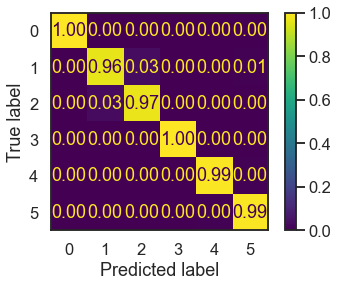

In [29]:
cf = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=GV_GBC.classes_)
disp.plot(values_format='.2f')
plt.show()
# remove  normalize='true' and replace .2f by d for values numerical values

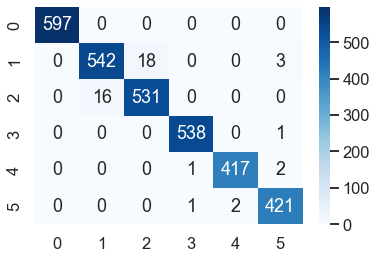

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have a variable y_test and y_pred defined earlier in your code

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)#after y_pred,if add, normalize='true' then results in %age

# Define a color map (e.g., 'Blues')
colors = 'Blues'

# Create a heatmap using seaborn
ax = sns.heatmap(cm, annot=True, fmt='d', cmap=colors)


the first confusion matrix showing results in %age and 2nd one in absolute numbers
- row of class 0 shows 100% correct predictions
- row of class 1 showing 542 correct predictions and 18 incorrect
- row of class 2 & class 5 showing 100% correct prediction where as class 4 is showing 2 incorrect predictions 
hence we can say that class 1 may be confused between two different position sitting and standing

Question 5
Create an AdaBoost model and fit it using grid search, much like question 4. Try a range of estimators between 100 and 200.
Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

In [41]:
pip install --upgrade joblib

Note: you may need to restart the kernel to use updated packages.


In [43]:
# Record the start time
start_time = time.time()
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=1) # we disable paraller processing to avoid the BrokenProcessPool 
                                    #  error on Windows.

GV_ABC = GV_ABC.fit(X_train, y_train)
# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 48699.47778725624 seconds


In [44]:
# to save files we use pickle function.
import pickle
pickle.dump(GV_ABC, open('gv_abc.p', 'wb'))  # wb means write bytes i.e we are saving it as bytes
                                            # we save thisfile of model as gv_abc.p

In [45]:
# to load the file from pickle as GV_ABC
GV_ABC=pickle.load(open('gv_abc.p', 'rb')) # rb means read bytes

In [46]:
# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01, n_estimators=100)

The error metrics. Note that the issues with class 1 and 2 appear to have become more problematic. Also note other issues for classes 3 - 5. AdaBoost is very sensitive to outliers, so that could be the problem here.

In [47]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       600
           1       0.00      1.00      0.00         1
           2       1.00      0.49      0.66      1106
           3       0.92      0.84      0.88       589
           4       0.73      0.95      0.82       320
           5       0.89      0.80      0.84       474

    accuracy                           0.75      3090
   macro avg       0.76      0.85      0.70      3090
weighted avg       0.94      0.75      0.81      3090



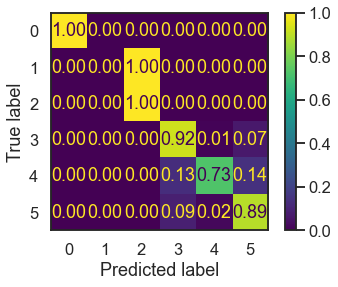

In [60]:
cf = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=GV_ABC.classes_)
disp.plot(values_format='.2f')
plt.show()

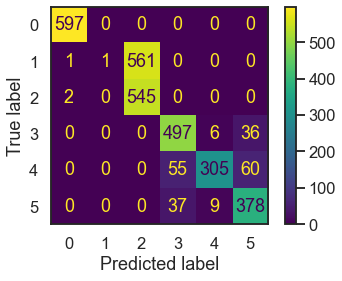

In [58]:
cf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=GV_ABC.classes_)
disp.plot(values_format='d')
plt.show()

The confusion matrix shows AdaBoostClassifier is wrongly miscalssifying Class 1 as class 2 due to the fact that AdaBoost is highly skewed bcs of outliers because it tries to fit the each point perfectly 

Question 6
Fit a logistic regression model with regularization.
Using VotingClassifier, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both) from questions 4 and 5.
Determine the error as before and compare the results to the appropriate gradient boosted model(s).
Plot the confusion matrix for the best model created in this set of exercises.


In [61]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression

# L2 regularized logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(X_train, y_train)

Check the errors and confusion matrix for the logistic regression model.

In [62]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       0.95      0.96      0.95       558
           2       0.95      0.95      0.95       547
           3       1.00      0.99      0.99       544
           4       0.98      1.00      0.99       413
           5       1.00      0.98      0.99       430

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



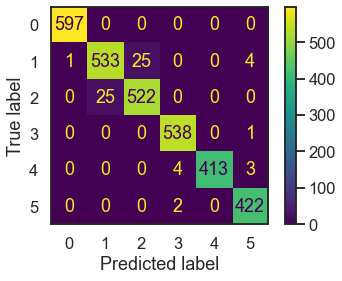

In [64]:
cf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=LR_L2.classes_)
disp.plot(values_format='d')
plt.show()

The result shows that class 1 and class 2 is confused and not showing accurate results

And now the stacked model with stacking of logistic regression and GBC

A voting classifier is a machine learning model that gains experience by training on a collection of several models and forecasts an output (class) based on the largest majority of votes. it averages the results of each classifier provided into the voting classifier. 

The concept is to build a single model that learns from various models and predicts output based on their aggregate majority of votes for each output class, rather than building separate specialized models and determining the accuracy for each of them.

There are primarily two different types of voting classifiers:
•	Hard Voting: In hard voting, the predicted output class is a class with the highest majority of votes, i.e., the class with the highest probability of being predicted by each classifier. For example, let’s say classifiers predicted the output classes as (Cat, Dog, Dog). As the classifiers predicted class “dog” a maximum number of times, we will proceed with Dog as our final prediction.
•	Soft Voting: In this, the average probabilities of the classes determine which one will be the final prediction. For example, let’s say the probabilities of the class being a “dog” is (0.30, 0.47, 0.53) and a “cat” is (0.20, 0.32, 0.40). So, the average for a class dog is 0.4333, and the cat is 0.3067, from this, we can confirm our final prediction to be a dog as it has the highest average probability


In [68]:
pip install --upgrade scikit-learn joblib


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in d:\computer\lib\site-packages (1.4.0)



In [ ]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft', n_jobs=1)
VC = VC.fit(X_train, y_train)

In [73]:
# to save files we use pickle function.
import pickle
pickle.dump(VC, open('vc.p', 'wb'))  # wb means write bytes i.e we are saving it as bytes
                                            # we save thisfile of model as vc.p

In [74]:
# to load the file from pickle as VC
VC=pickle.load(open('vc.p', 'rb')) # rb means read bytes

In [80]:
VC

VotingClassifier(estimators=[('LR_L2',
                              LogisticRegression(max_iter=500, solver='saga')),
                             ('GBC',
                              GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                                           n_jobs=-1,
                                           param_grid={'learning_rate': [0.1,
                                                                         0.01,
                                                                         0.001,
                                                                         0.0001],
                                                       'max_features': [1, 2, 3,
                                                                        4],
                                                       'n_estimators': [15, 25,
                                                                        50, 100,
                                                                        200,
                                                                        400],
                                                       'subsample': [1.0, 0.5]},
                                           scoring='accuracy'))],
                 n_jobs=1, voting='soft')

Performance for the voting classifier should improve relative to either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder to try the simplest model first. In some cases, its performance will be good enough.

In [93]:
for estimator in VC.estimators:
    print(estimator)

('LR_L2', LogisticRegression(max_iter=500, solver='saga'))
('GBC', GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                         'max_features': [1, 2, 3, 4],
                         'n_estimators': [15, 25, 50, 100, 200, 400],
                         'subsample': [1.0, 0.5]},
             scoring='accuracy'))


In [97]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.95      0.98      0.96       563
           2       0.98      0.94      0.96       547
           3       0.99      1.00      0.99       539
           4       1.00      0.99      0.99       420
           5       0.99      0.99      0.99       424

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



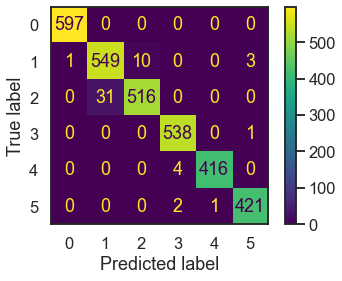

In [98]:
cf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=VC.classes_)
disp.plot(values_format='d')
plt.show()


In [95]:
start_time = time.time()
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

LR_L2 = LogisticRegression(max_iter=500, solver='saga')
GBC = GradientBoostingClassifier(random_state=42)

VC = VotingClassifier(estimators=[('LR_L2', LR_L2), ('GBC', GBC)])

# Fit the VotingClassifier on the training data
VC.fit(X_train, y_train)

# Make predictions on the test data
y_pred = VC.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Time taken: {elapsed_time} seconds")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.95      0.98      0.96       563
           2       0.98      0.94      0.96       547
           3       0.99      1.00      0.99       539
           4       1.00      0.99      0.99       420
           5       0.99      0.99      0.99       424

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090

Time taken: 4697.531503915787 seconds


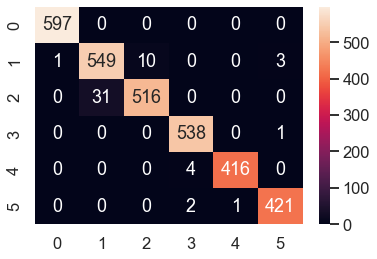

In [96]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
import pickle

# Example Python object
data = {'name': 'John', 'age': 30, 'city': 'New York'}

# Pickle the object and write it to a file
with open('data.pkl', 'wb') as file:
    pickle.dump(data, file)
#Unpickle a Python Object:
#You can use the pickle.load() function to read a serialized object from a file and reconstruct it.

import pickle

# Unpickle the object from the file. 'rb' is used to open the file in binary mode for reading. 
with open('data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

print(loaded_data)
# Output: {'name': 'John', 'age': 30, 'city': 'New York'}